### Notebook for the label transfer of HLCA Epithelial-Stromal to Healthy-CTRL with `scANVI`

- **Developed by:** Carlos Talavera-López Ph.D
- **Institute of Computational Biology - Computational Health Department - Helmholtz Munich**
- v230511

### Import required modules

In [1]:
import torch
import scvi
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

Global seed set to 0
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                 9.4.0
absl                NA
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
brotli              NA
certifi             2022.12.07
cffi                1.15.1
charset_normalizer  2.1.1
chex                0.1.6
colorama            0.4.6
contextlib2         NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
docrep              0.3.2
executing           1.2.0
flax                0.5.0
fsspec              2023.3.0
h5py                3.8.0
hypergeom_ufunc     NA
idna                3.4
igraph              0.10.4
importlib_resources NA
invgauss_ufunc      NA
ipykernel           6.15.0
ipywidgets          8.0.6
jax                 0.4.6
jaxlib              0.4.6
jedi                0.18.2
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.1
lightning

### Read in Healthy data

In [3]:
hlca_healthy = sc.read_h5ad('../data/HLCA_Healthy_Epithelial_v1.1.h5ad')
hlca_healthy

AnnData object with n_obs × n_vars = 278311 × 27619
    obs: 'ann_finest_level', 'sample', 'disease', 'organism', 'sex', 'tissue', 'seed_labels', 'donor', 'cell_states'
    var: 'feature_name', 'feature_reference', 'feature_biotype'

In [4]:
hlca_healthy.obs['organism'].cat.categories

Index(['Homo sapiens'], dtype='object')

In [5]:
hlca_healthy.obs['cell_states'].value_counts()

AT2                          61429
Suprabasal                   41158
Basal resting                38955
Goblet (nasal)               35833
Multiciliated (non-nasal)    35225
Club (nasal)                 26068
Club (non-nasal)              9955
AT1                           7937
Multiciliated (nasal)         4869
Hillock-like                  4600
pre-TB secretory              4393
Goblet (bronchial)            1670
AT0                           1440
Deuterosomal                  1004
AT2 proliferating              976
Goblet (subsegmental)          968
Myofibroblasts                 716
Ionocyte                       561
Mesothelium                    230
Tuft                           165
Neuroendocrine                 159
Name: cell_states, dtype: int64

- Remove cells with 'None' annotation

In [6]:
sc.pp.filter_genes(hlca_healthy, min_cells = 3)
hlca_healthy.obs['cell_states'].value_counts()

AT2                          61429
Suprabasal                   41158
Basal resting                38955
Goblet (nasal)               35833
Multiciliated (non-nasal)    35225
Club (nasal)                 26068
Club (non-nasal)              9955
AT1                           7937
Multiciliated (nasal)         4869
Hillock-like                  4600
pre-TB secretory              4393
Goblet (bronchial)            1670
AT0                           1440
Deuterosomal                  1004
AT2 proliferating              976
Goblet (subsegmental)          968
Myofibroblasts                 716
Ionocyte                       561
Mesothelium                    230
Tuft                           165
Neuroendocrine                 159
Name: cell_states, dtype: int64

In [7]:
hlca_healthy

AnnData object with n_obs × n_vars = 278311 × 27619
    obs: 'ann_finest_level', 'sample', 'disease', 'organism', 'sex', 'tissue', 'seed_labels', 'donor', 'cell_states'
    var: 'feature_name', 'feature_reference', 'feature_biotype', 'n_cells'

### Fix reference var names

In [8]:
hlca_healthy.var.reset_index(inplace = True)
hlca_healthy.var.set_index('feature_name', inplace = True)
hlca_healthy.var

ensembl_id feature_reference feature_biotype  n_cells
feature_name                                                             
TSPAN6         ENSG00000000003    NCBITaxon:9606            gene    95774
TNMD           ENSG00000000005    NCBITaxon:9606            gene       81
DPM1           ENSG00000000419    NCBITaxon:9606            gene    81504
SCYL3          ENSG00000000457    NCBITaxon:9606            gene    21761
C1orf112       ENSG00000000460    NCBITaxon:9606            gene     6364
...                        ...               ...             ...      ...
RP11-124N19.4  ENSG00000283075    NCBITaxon:9606            gene       37
RP11-11M20.4   ENSG00000283078    NCBITaxon:9606            gene     1402
LLNLR-245B6.1  ENSG00000283103    NCBITaxon:9606            gene    49489
MGC4859        ENSG00000283117    NCBITaxon:9606            gene      114
RP11-299P2.2   ENSG00000283125    NCBITaxon:9606            gene       57

[27619 rows x 4 columns]

### Read in other unannotated datasets

In [29]:
query = sc.read_h5ad('../data/Marburg_All_ctl230404_leiden_states.raw.h5ad')
query

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout_by_coun

In [30]:
query_healthy = query[query.obs['disease'].isin(['healthy'])]
query_healthy

View of AnnData object with n_obs × n_vars = 46354 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout

In [31]:
healthy_ctrl = query_healthy[query_healthy.obs['infection'].isin(['CTRL'])]
healthy_ctrl.obs['seed_labels'] = 'Unknown'
healthy_ctrl.obs['C_scANVI_old'] = healthy_ctrl.obs['C_scANVI']
healthy_ctrl

/var/folders/rx/f17v355x1xqdpm4hlmym_zvw0000gn/T/ipykernel_32465/3618638729.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  healthy_ctrl.obs['seed_labels'] = 'Unknown'


AnnData object with n_obs × n_vars = 23667 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states', 'seed_labels', 'C_scANVI_old'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_c

In [12]:
adata = hlca_healthy.concatenate(healthy_ctrl, batch_key = 'group_LT', batch_categories = ['hlca_epistr', 'healthy_ctrl'], join = 'inner')
adata

/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 301978 × 19356
    obs: 'ann_finest_level', 'sample', 'disease', 'organism', 'sex', 'tissue', 'seed_labels', 'donor', 'cell_states', 'age', 'ethnicity', 'PaCO2', 'infection', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states', 'C_scANVI_old', 'group_LT'
    var: 'mt-healthy_ctrl', 'ribo-healthy_ctrl', 'n_cells_by_counts-V1-healthy_ctrl', 'mean_counts-V1-healthy_ctrl', 'pct_dropout_by_counts-V1-healthy_ctrl', 'total_counts-V1-healthy_ctrl', 'n_cells_by_counts-V2-healthy_ctrl', 'mean_counts-V2-healthy_ctrl', 'pct_dropout_by_counts-V2-healthy_ctrl', 'total_counts-V2-healthy_ctrl',

### Select HVGs

In [13]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category') 

In [14]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

In [16]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True,
    span = 1
)

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 301978 × 7000
    obs: 'ann_finest_level', 'sample', 'disease', 'organism', 'sex', 'tissue', 'seed_labels', 'donor', 'cell_states', 'age', 'ethnicity', 'PaCO2', 'infection', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states', 'C_scANVI_old', 'group_LT'
    var: 'mt-healthy_ctrl', 'ribo-healthy_ctrl', 'n_cells_by_counts-V1-healthy_ctrl', 'mean_counts-V1-healthy_ctrl', 'pct_dropout_by_counts-V1-healthy_ctrl', 'total_counts-V1-healthy_ctrl', 'n_cells_by_counts-V2-healthy_ctrl', 'mean_counts-V2-healthy_ctrl', 'pct_dropout_by_counts-V2-healthy_ctrl', 'total_counts-V2-healthy_ctrl', 

### Transfer of annotation with scANVI

In [17]:
scvi.model.SCVI.setup_anndata(adata, batch_key = 'donor', labels_key = "seed_labels", layer = 'counts')

In [18]:
scvi_model = scvi.model.SCVI(adata, n_latent = 50, n_layers = 3, dispersion = 'gene-batch', gene_likelihood = 'nb')

In [19]:
scvi_model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 26/26: 100%|██████████| 26/26 [1:11:36<00:00, 155.08s/it, loss=3.75e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=26` reached.


Epoch 26/26: 100%|██████████| 26/26 [1:11:36<00:00, 165.27s/it, loss=3.75e+03, v_num=1]


### Label transfer with `scANVI` 

In [20]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [21]:
scanvi_model.train()


INFO     Training for 9 epochs.                                                                                    


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 9/9: 100%|██████████| 9/9 [28:45<00:00, 195.65s/it, loss=3.96e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=9` reached.


Epoch 9/9: 100%|██████████| 9/9 [28:45<00:00, 191.70s/it, loss=3.96e+03, v_num=1]


In [22]:
adata.obs["C_scANVI_new"] = scanvi_model.predict(adata)

- Extract latent representation

In [23]:
adata.obsm["C_scANVI_new"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:43)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:06:05)


/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:39

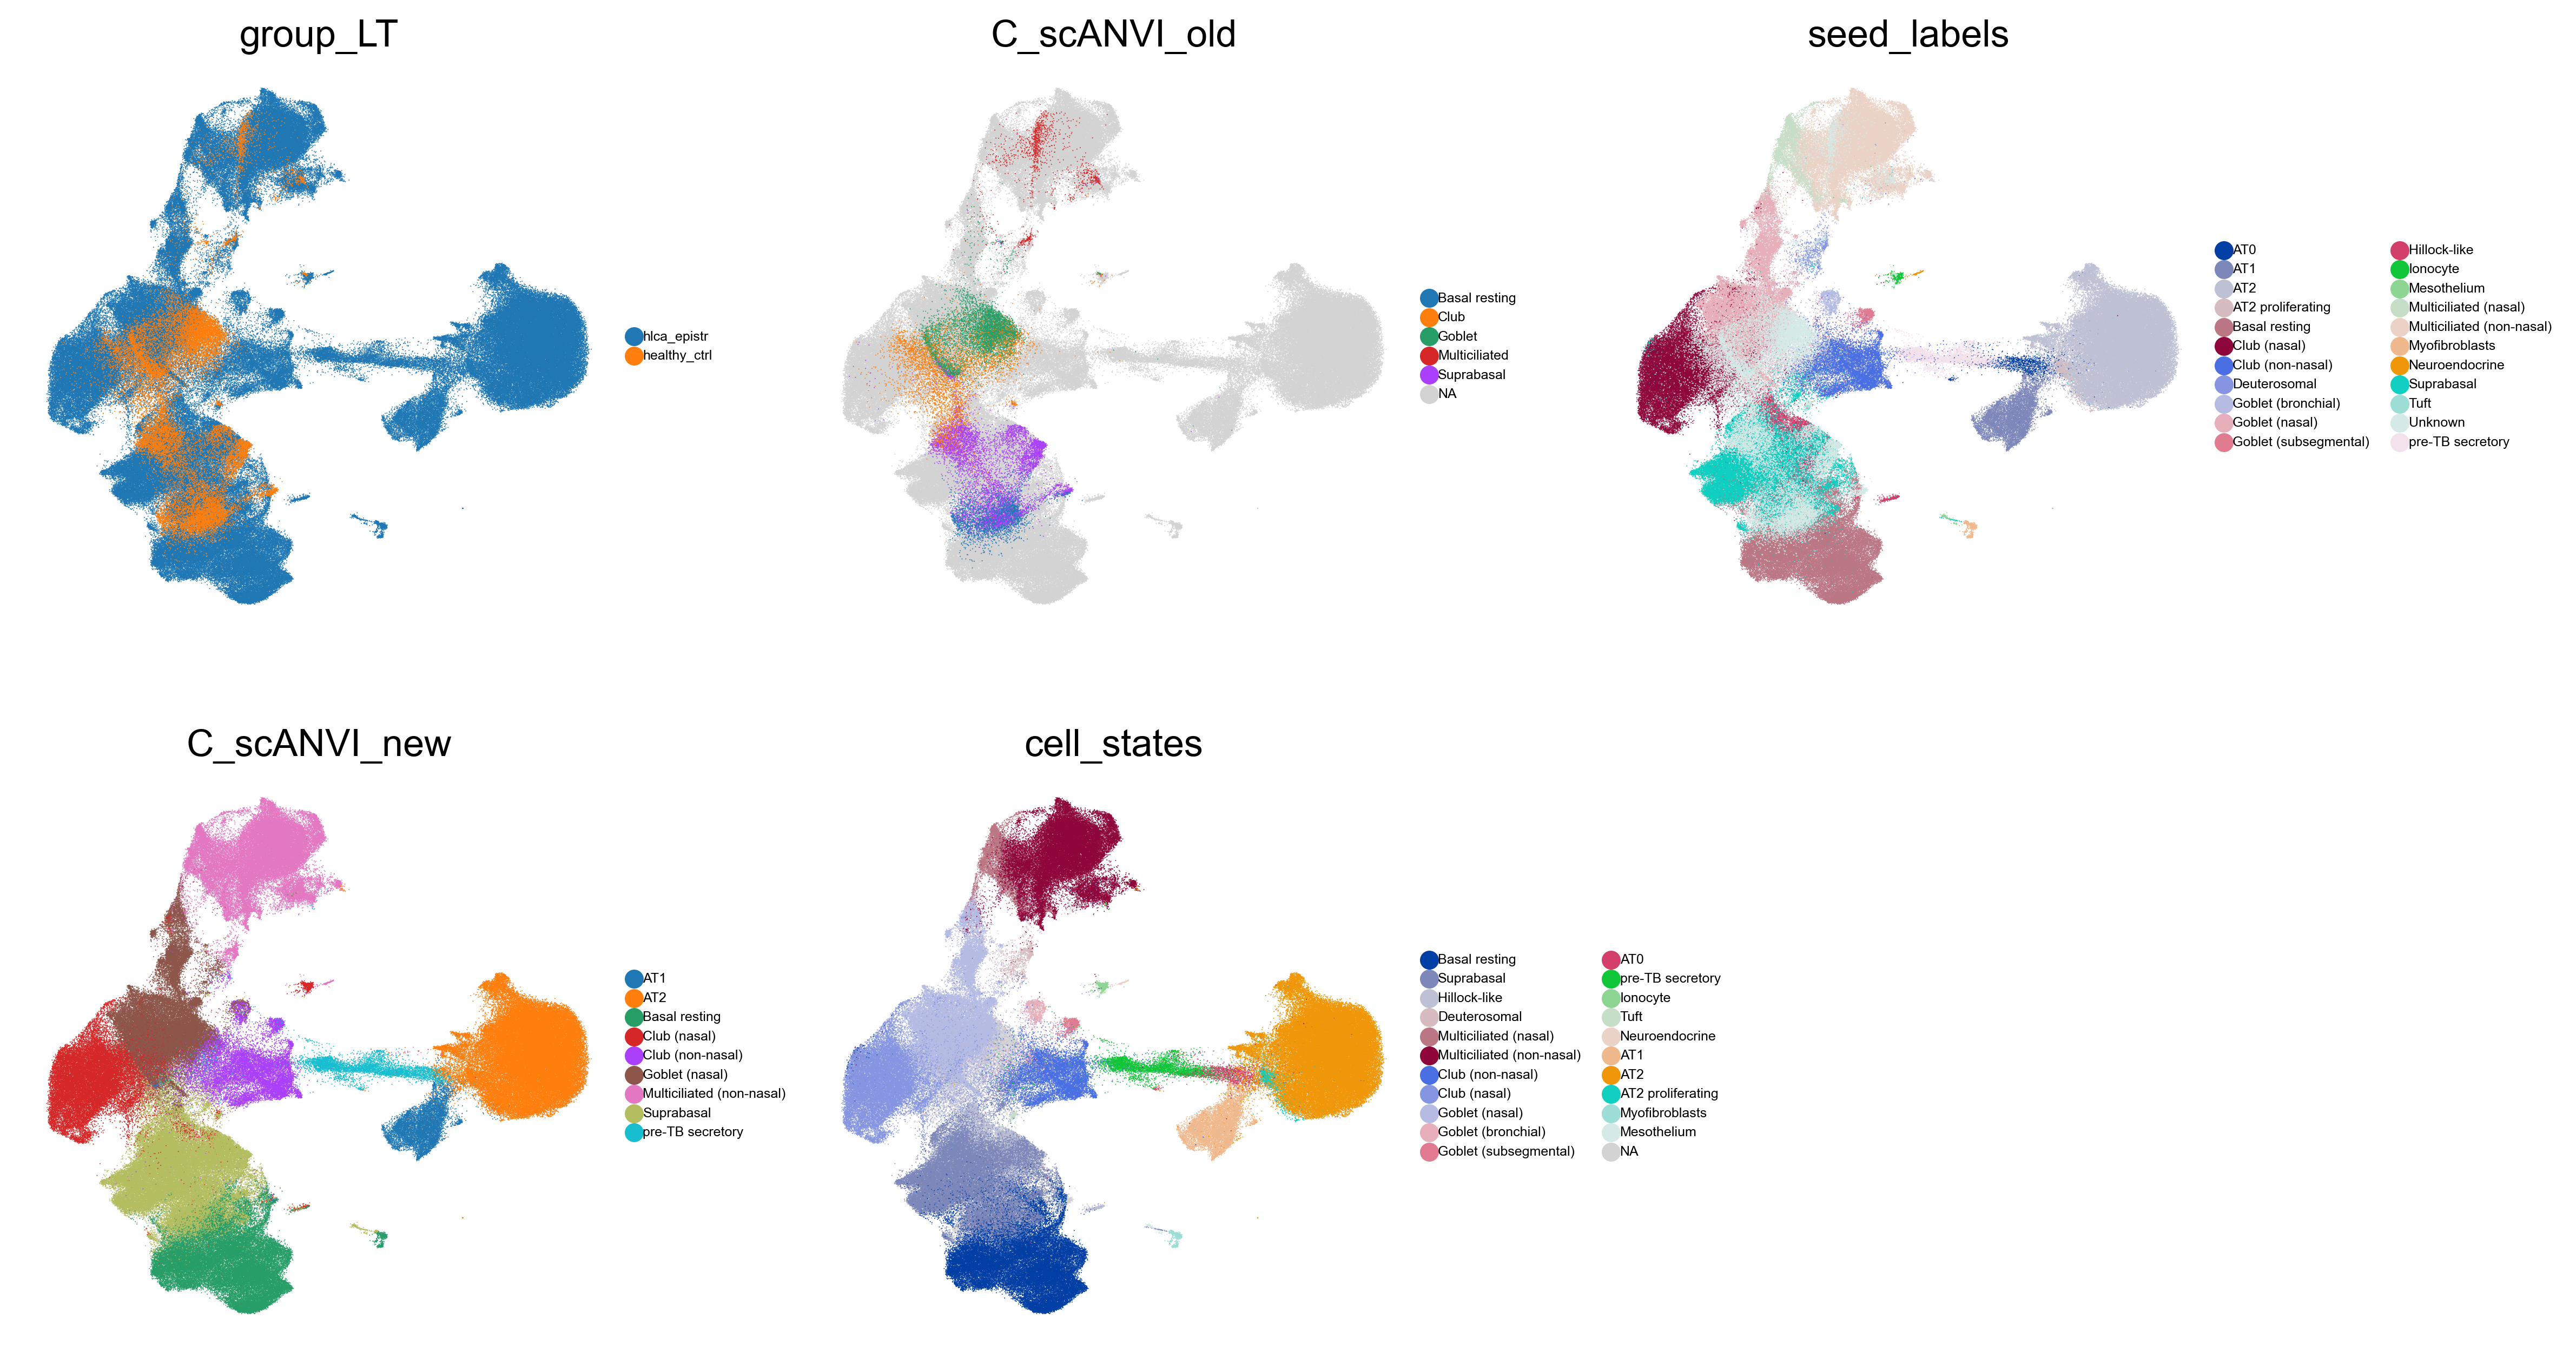

In [25]:
sc.pp.neighbors(adata, use_rep = "C_scANVI_new", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 1, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['group_LT', 'C_scANVI_old', 'seed_labels', 'C_scANVI_new', 'cell_states'], size = 0.6, legend_fontsize = 5, ncols = 3)

### Export annotated sample object 

In [26]:
query_annotated = adata[adata.obs['group'].isin(['healthy_ctrl'])]
query_annotated.obs_names

Index(['588032-ST07_CSE_CTRL-V1-healthy_ctrl',
       '476315-ST07_CSE_CTRL-V1-healthy_ctrl',
       '210114-ST07_CSE_CTRL-V1-healthy_ctrl',
       '593947-ST07_CSE_CTRL-V1-healthy_ctrl',
       '300107-ST07_CSE_CTRL-V1-healthy_ctrl',
       '558312-ST07_CSE_CTRL-V1-healthy_ctrl',
       '807413-ST07_CSE_CTRL-V1-healthy_ctrl',
       '763870-ST07_CSE_CTRL-V1-healthy_ctrl',
       '132925-ST07_CSE_CTRL-V1-healthy_ctrl',
       '606859-ST07_CSE_CTRL-V1-healthy_ctrl',
       ...
       '1647838-GER02_CTRL-V6-healthy_ctrl',
       '10059318-GER02_CTRL-V6-healthy_ctrl',
       '3113495-GER02_CTRL-V6-healthy_ctrl',
       '7983748-GER02_CTRL-V6-healthy_ctrl',
       '10326936-GER02_CTRL-V6-healthy_ctrl',
       '1643539-GER02_CTRL-V6-healthy_ctrl',
       '1044875-GER02_CTRL-V6-healthy_ctrl',
       '9882253-GER02_CTRL-V6-healthy_ctrl',
       '1638166-GER02_CTRL-V6-healthy_ctrl',
       '3419607-GER02_CTRL-V6-healthy_ctrl'],
      dtype='object', length=23667)

In [27]:
query_annotated.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in query_annotated.obs.index])
query_annotated.obs.index

Index(['588032-ST07_CSE_CTRL-V1', '476315-ST07_CSE_CTRL-V1',
       '210114-ST07_CSE_CTRL-V1', '593947-ST07_CSE_CTRL-V1',
       '300107-ST07_CSE_CTRL-V1', '558312-ST07_CSE_CTRL-V1',
       '807413-ST07_CSE_CTRL-V1', '763870-ST07_CSE_CTRL-V1',
       '132925-ST07_CSE_CTRL-V1', '606859-ST07_CSE_CTRL-V1',
       ...
       '1647838-GER02_CTRL-V6', '10059318-GER02_CTRL-V6',
       '3113495-GER02_CTRL-V6', '7983748-GER02_CTRL-V6',
       '10326936-GER02_CTRL-V6', '1643539-GER02_CTRL-V6',
       '1044875-GER02_CTRL-V6', '9882253-GER02_CTRL-V6',
       '1638166-GER02_CTRL-V6', '3419607-GER02_CTRL-V6'],
      dtype='object', length=23667)

In [32]:
healthy_ctrl.obs['C_scANVI_new'] = query_annotated.obs['C_scANVI_new'].copy()
healthy_ctrl.obs_names

Index(['588032-ST07_CSE_CTRL-V1', '476315-ST07_CSE_CTRL-V1',
       '210114-ST07_CSE_CTRL-V1', '593947-ST07_CSE_CTRL-V1',
       '300107-ST07_CSE_CTRL-V1', '558312-ST07_CSE_CTRL-V1',
       '807413-ST07_CSE_CTRL-V1', '763870-ST07_CSE_CTRL-V1',
       '132925-ST07_CSE_CTRL-V1', '606859-ST07_CSE_CTRL-V1',
       ...
       '1647838-GER02_CTRL-V6', '10059318-GER02_CTRL-V6',
       '3113495-GER02_CTRL-V6', '7983748-GER02_CTRL-V6',
       '10326936-GER02_CTRL-V6', '1643539-GER02_CTRL-V6',
       '1044875-GER02_CTRL-V6', '9882253-GER02_CTRL-V6',
       '1638166-GER02_CTRL-V6', '3419607-GER02_CTRL-V6'],
      dtype='object', length=23667)

In [33]:
healthy_ctrl.obs['C_scANVI_new'].cat.categories

Index(['AT1', 'AT2', 'Basal resting', 'Club (nasal)', 'Club (non-nasal)',
       'Goblet (nasal)', 'Multiciliated (non-nasal)', 'Suprabasal',
       'pre-TB secretory'],
      dtype='object')

In [34]:
healthy_ctrl.obs['C_scANVI_new'].value_counts()

Suprabasal                   9110
Goblet (nasal)               5989
Basal resting                2888
Club (nasal)                 2243
Club (non-nasal)             1676
Multiciliated (non-nasal)    1383
pre-TB secretory              249
AT1                           111
AT2                            18
Name: C_scANVI_new, dtype: int64

In [36]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis = 0).astype(int), adata.X.sum(axis = 0))

In [37]:
X_is_raw(healthy_ctrl)

True

### Export annotated Helathy-CTRL object with raw counts

In [38]:
healthy_ctrl.write('../data/Marburg_Healthy_CTRL_ctl230511_scANVI_annot.raw.h5ad')